In [45]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.io import fits
import numpy as onp
import pickle

In [2]:
import jax
import jax.numpy as np
from jax import jit, value_and_grad
from jax.ops import index, index_update

In [3]:
def get_power_spectrum(image):
    return np.abs(np.fft.fftshift(np.fft.fft2(image)))**2

def get_log10_power_spectrum(image):
    return np.log10(get_power_spectrum(image))

def get_radial(npix):
    c = npix//2
    xrange = np.arange(-c, c)
    X, Y = np.meshgrid(xrange, xrange)
    R = np.hypot(X, Y)
    return R

def get_outer_sum(array, r):
    R = get_radial(array.shape[0])
    sum_out = np.sum(array[R > r])
    return sum_out

---

## Load and Examine data

In [4]:
file_names = [
    "nb_05.59.13_2050.fits",
    "nb_06.00.06_2051.fits",
    "nb_06.01.00_2052.fits",
]

In [5]:
files_in = []

for i in range(len(file_names)):
    files_in.append(fits.open("DSSI_data/{}".format(file_names[i]))[0].data)
        
images = np.array(files_in)

/suphys/ldes9555/anaconda3/envs/main/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [6]:
npix = 256

In [7]:
%%time

# Get power spectrums
power_spectrums = get_power_spectrum(images)

# Get mean power spectrum
mean_power_spectrum = np.mean(power_spectrums, axis=1)

# Get mean image
mean_image = np.mean(images, axis=1)

# Get mean image power spectrum
mean_image_power_spectrum = get_power_spectrum(mean_image)

CPU times: user 26.4 s, sys: 1.6 s, total: 28 s
Wall time: 26 s


---

## View data

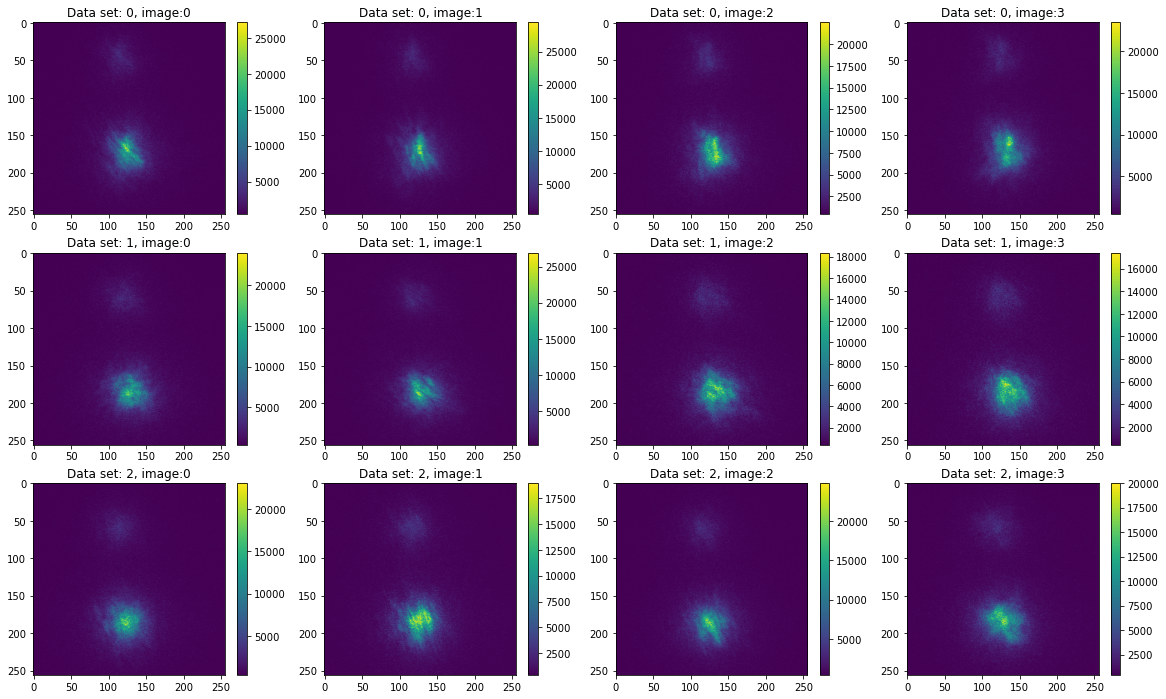

In [8]:
plt.figure(figsize=(20, 12))

idx = 1
for i in range(3):
    for j in range(4):
        plt.subplot(3, 4, idx)
        plt.imshow(images[i, j])
        plt.title("Data set: {}, image:{}".format(i, j))
        plt.colorbar()
        idx += 1
plt.show()

---

## View power spectrums

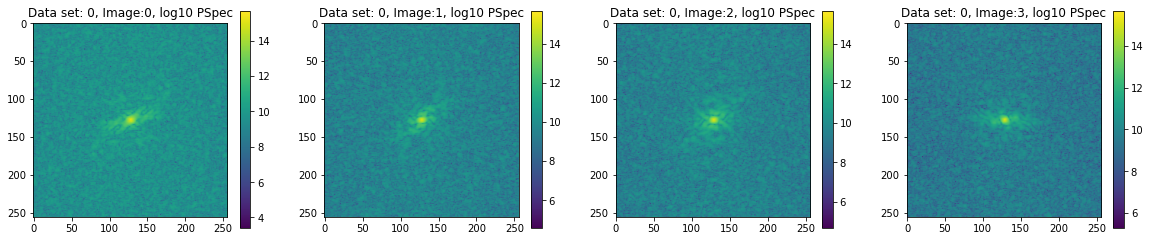

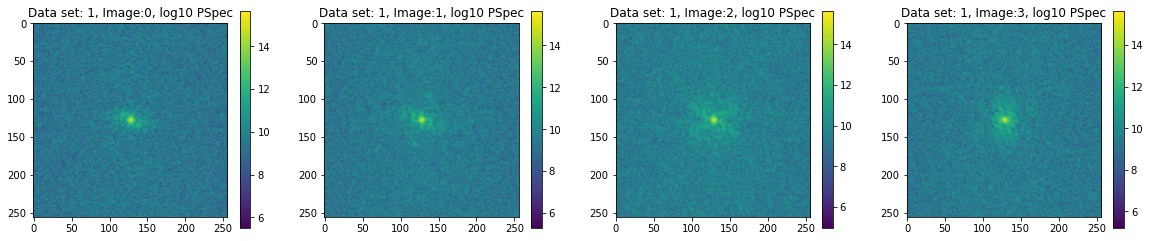

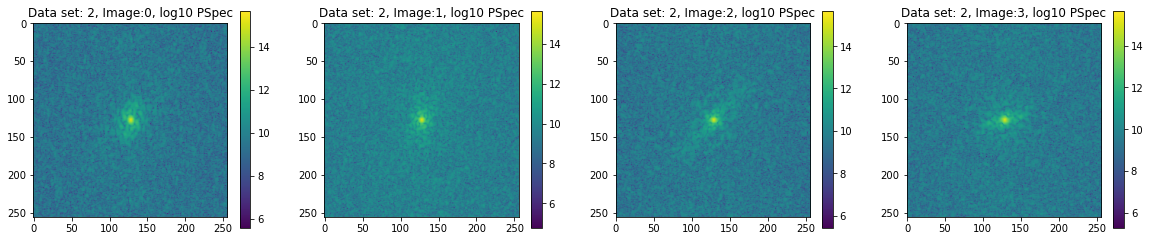

In [9]:
for i in range(3):
    plt.figure(figsize=(20, 4))
    for j in range(4):
        
        plt.subplot(1, 4, j+1)
        plt.imshow(np.log10(power_spectrums[i, j]))
        plt.title("Data set: {}, Image:{}, log10 PSpec".format(i, j))
        plt.colorbar()
        
    plt.show()

---

## View means, mean of power spectrums, and mean image power spectrums

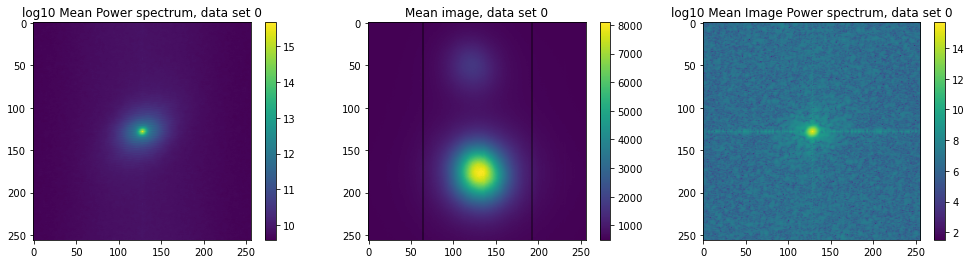

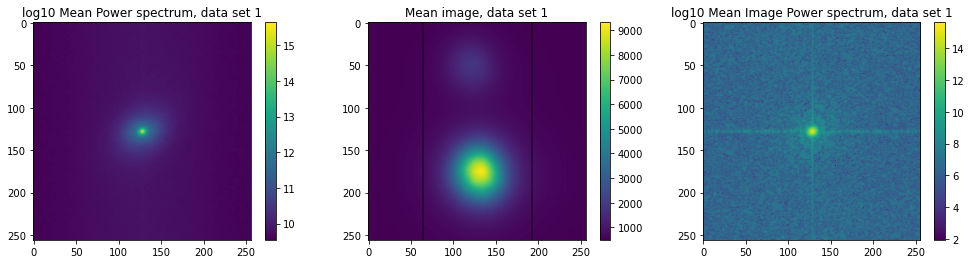

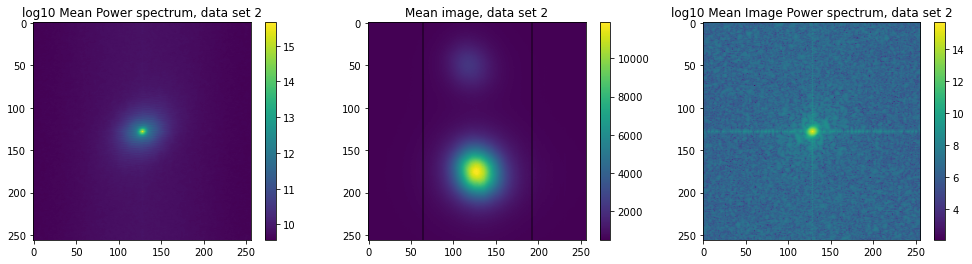

In [31]:
for i in range(len(mean_image)):

    plt.figure(figsize=(17, 4))
    
    plt.subplot(1, 3, 1)
    plt.title("log10 Mean Power spectrum, data set {}".format(i))
    plt.imshow(np.log10(mean_power_spectrum[i]))
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title("Mean image, data set {}".format(i))
    plt.axvline(64, c='k', alpha=0.5)
    plt.axvline(192, c='k', alpha=0.5)
    plt.imshow(mean_image[i])
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title("log10 Mean Image Power spectrum, data set {}".format(i))
    plt.imshow(np.log10(mean_image_power_spectrum[i]))
    plt.colorbar()
    
    plt.show()

---

## Gradient descend on FF

### Algorithm:

We observe an image I which is constructed from each of these components:

- Image: I
- True FF: TFF
- Detector noise: BG
- PSF: PSF
- Seeing Noise: S

They combine as follows to give us our observed image:

> $ \text{I} = \text{TFF} \times (\text{PSF}*\text{S}) + \text{BG} $

where * is a convolution of the underlying PSF and the seeing.

The PSF and seeing noise S are both propaged through the optical system and hence cannot induce frequncies in the power spectrum above that determined by the diffraction limit. Since the BG noise and TFF are not subject to this same constraint all the amplitude observed in the power spectrum beyond some particular radius must nessecarily be as result of either the TFF or BG.

Over the time frames we are observing we will assume that the TFF is unchanged across all frames. The detector noise (BG) however changes in every frame, resulting in its contribution over a large number of frames averaging out to constant which should not induce power beyond the diffraction limit.

This algorithm takes advantage of this fact to learn the TFF from data with no knowledge of the underlying PSF or seeing noise by minimising the power outisde of the periphery defined by the diffraction limit. In reality there is no hard boundary as the detectors observer over a spectrum, however the cameras used only observe over ~50nm and hence this effect is ignored.

We therefore 'correct' for the TFF using the following equation

> $ \text{I}_{corrected} = \text{X} \times \text{I} = \text{X} \times [ \text{TFF} \times (\text{PSF}*\text{S}) + \text{BG} ] $

> $ \text{P} = |\mathcal{\text{F}}\{\text{I}\}|^2 $

> $ \text{Error}_1 = \sum_{\text{images}} \Big[ \sum_{\text{pixels}}^{f > f_{dlim}}(P) \Big] $

> $ \text{Error}_2 =  \sum_{\text{pixels}}^{f > f_{dlim}} \Big[ \sum_{\text{images}}(P) \Big] $ (Assumed incorrect)

This metric results in our value 'X' being the inverse of the TFF, ie Found Flat Field 

> $ FFF = \frac{1}{X} \approx TFF $


---


In [11]:
def ADAM(X, grad, LR, i, m, v, b1=0.9, b2=0.999, epsilon=1):
    m = b1 * m + (1 - b1) * grad
    v = b2 * v + (1 - b2) * np.power(grad, 2)
    m_hat = m / (1 - np.power(b1, i+1))
    v_hat = v / (1 - np.power(b2, i+1))
    X_new = X - LR * m_hat / (np.sqrt(v_hat) + epsilon)
    return X_new, m, v

def get_power_spec_min(image):
    return np.abs(np.fft.fftshift(np.fft.fft2(image)))**2
get_power_spec = jit(get_power_spec_min)


def error(X, images, r=0):
    npix = 256
#     r = 128 # Assume exactly nyquist sampled
    
    # Get Radial values and frequncy mask
    xrange = np.arange(-npix//2, npix//2)
    Xs, Ys = np.meshgrid(xrange, xrange)
    R = np.hypot(Xs, Ys)
    freq_mask = R > r
    
    # Apply bounds 
    X = np.maximum(X, 1) # Apply Floor
    X = np.minimum(X, 1.2) # Apply ceiling
    
    # Reshape X into a square
    FF_inv = X.reshape([npix, npix])
    
    # Apply FF correction to images
    corrected_images = FF_inv * images
    
    # Get the power spectrum of all the images
    images_power_spec = get_power_spec(corrected_images)

    # Apply the frequency mask
    masked_images = freq_mask * images_power_spec
    
    # Get sum of frequncies above the diffraction limit
    power_spec_outer_sum = np.sum(masked_images)

    return power_spec_outer_sum

err_grad = value_and_grad(error, argnums=0)

---

### Run on all data sets to compare FF out

In [29]:
errs_out = []
Xs_out = []

for j in tqdm(range(len(images))):
    X = 1.1*np.ones(npix**2)
    LR = 0.5e-1
    m, v = 0, 0

    errs = []
    Xs = []

#     epochs = [50, 100, 150, 200]
    epochs = [25]
    for i in tqdm(range(epochs[-1])):

        # Reduce LR 
        if i in epochs:
            LR *= 0.1

        # Get gradients and update X
#         err, grads = err_grad(X, images[j], r=128)
        err, grads = err_grad(X, images[j], r=132)
        errs.append(err)
        Xs.append(X)
        X, m, v = ADAM(X, grads, LR, i, m, v)

        # Apply bounds 
        X = np.maximum(X, 1) # Apply Floor

    errs_out.append(errs)
    Xs_out.append(Xs)

errs_out = onp.array(errs_out)
errs_out = np.array(errs_out)

Xs_out = onp.array(Xs_out)
Xs_out = np.array(Xs_out)

In [30]:
# Save
with open("files/errs_out_DSSI_test.pkl", 'wb') as f:
    pickle.dump(errs_out, f)
    
with open("files/Xs_out_DSSI_test.pkl", 'wb') as f:
    pickle.dump(Xs_out, f)

# # Load
# with open("files/errs_out_DSSI_test.pkl", 'rb') as f:
#     errs_out = pickle.load(f)
    
# with open("files/Xs_out_DSSI_test.pkl", 'rb') as f:
#     Xs_out = pickle.load(f)

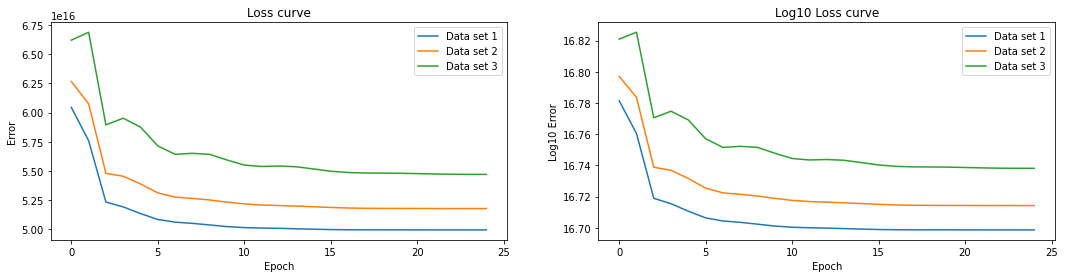

In [46]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.plot(errs_out[0], label="Data set 1")
plt.plot(errs_out[1], label="Data set 2")
plt.plot(errs_out[2], label="Data set 3")
plt.legend()
plt.title("Loss curve")
plt.ylabel("Error")
plt.xlabel("Epoch")

plt.subplot(1, 2, 2)
plt.plot(onp.log10(errs_out[0]), label="Data set 1")
plt.plot(onp.log10(errs_out[1]), label="Data set 2")
plt.plot(onp.log10(errs_out[2]), label="Data set 3")
plt.legend()
plt.title("Log10 Loss curve")
plt.ylabel("Log10 Error")
plt.xlabel("Epoch")

plt.show()

In [33]:
# idxs = [50, 100, 150, 200]

# for j in range(3):
#     print("\nData Set {}".format(j+1))
    
# #     plt.figure(figsize=(20, 4))

# #     for i in range(4):
# #         plt.subplot(1, 4, i+1)
# #         plt.imshow(Xs_out[j][idxs[i]-1].reshape(npix, npix), cmap='seismic')
# #         plt.title("X, Epoch: {}".format(idxs[i]))
# #         plt.colorbar()
# #     plt.show()

#     plt.figure(figsize=(20, 4))
#     for i in range(4):
#         plt.subplot(1, 4, i+1)
#         plt.imshow(1/Xs_out[j][idxs[i]-1].reshape(npix, npix), cmap='seismic')
#         plt.colorbar()
#         plt.title("Flat Field, Epoch: {}".format(idxs[i]))
#     plt.show()

In [38]:
Xs_final = Xs_out[:, -1, :]
FFs_final = 1/Xs_final.reshape([3, npix, npix])

# Remove the FF that applies to the BG noise
FFs_final = index_update(FFs_final, index[:, :, :64], 1)
FFs_final = index_update(FFs_final, index[:, :, 192:], 1)
FF_power_specs = get_power_spec(FFs_final)

# Set the Flat field to deviate from 0 rather than 1 to better observe correlation
FFs_final_zeroed = np.abs(1 - FFs_final)

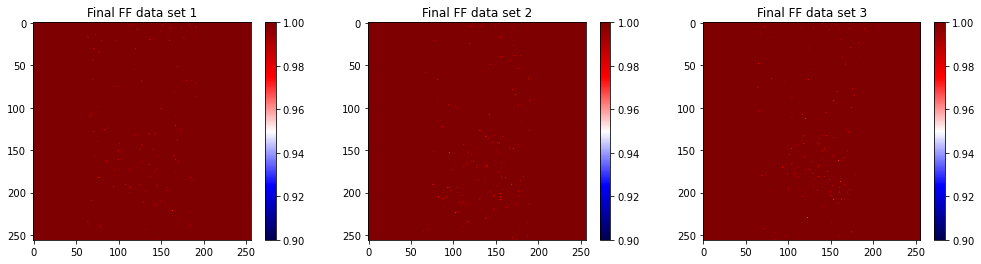

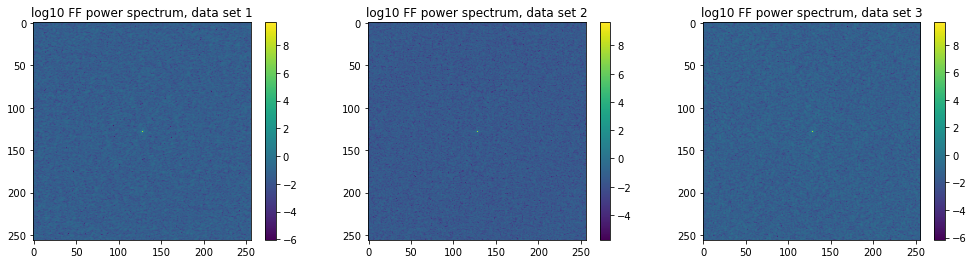

In [39]:
plt.figure(figsize=(17, 4))

plt.subplot(1, 3, 1)
plt.imshow(FFs_final[0], cmap='seismic', vmin=0.9)
plt.title("Final FF data set 1")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(FFs_final[1], cmap='seismic', vmin=0.9)
plt.title("Final FF data set 2")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(FFs_final[2], cmap='seismic', vmin=0.9)
plt.title("Final FF data set 3")
plt.colorbar()

plt.show()

plt.figure(figsize=(17, 4))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(np.log10(FF_power_specs[i]))
    plt.title("log10 FF power spectrum, data set {}".format(i+1))
    plt.colorbar()
plt.show()

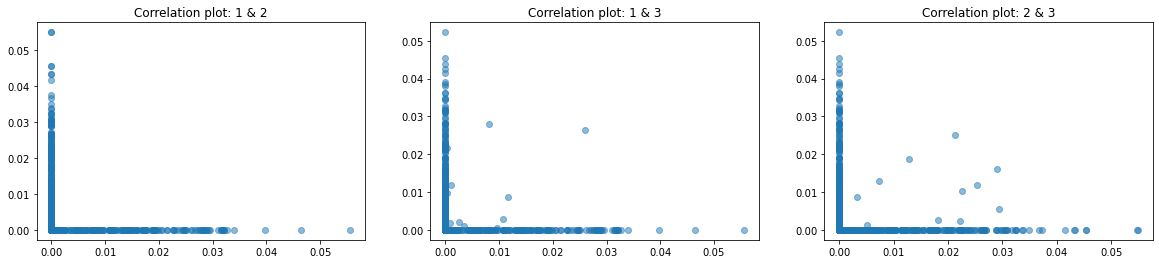

In [40]:
plt.figure(figsize=(20, 4))

plt.subplot(1, 3, 1)
plt.scatter(FFs_final_zeroed[0].ravel(), FFs_final_zeroed[1].ravel(),alpha=0.5)
plt.title("Correlation plot: 1 & 2")

plt.subplot(1, 3, 2)
plt.scatter(FFs_final_zeroed[0].ravel(), FFs_final_zeroed[2].ravel(),alpha=0.5)
plt.title("Correlation plot: 1 & 3")

plt.subplot(1, 3, 3)
plt.scatter(FFs_final_zeroed[1].ravel(), FFs_final_zeroed[2].ravel(),alpha=0.5)
plt.title("Correlation plot: 2 & 3")

plt.show()

In [41]:
corr12 = jax.scipy.signal.correlate2d(FFs_final_zeroed[0], FFs_final_zeroed[1])
corr13 = jax.scipy.signal.correlate2d(FFs_final_zeroed[0], FFs_final_zeroed[2])
corr23 = jax.scipy.signal.correlate2d(FFs_final_zeroed[1], FFs_final_zeroed[2])

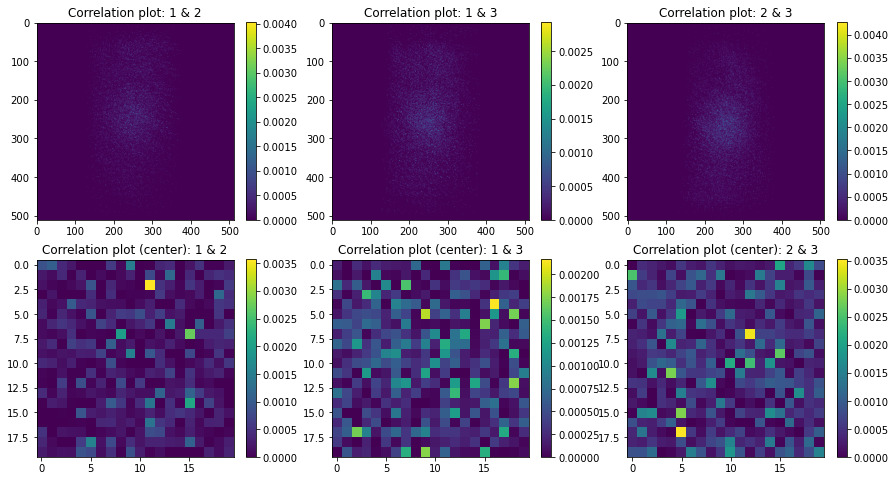

In [42]:
c = corr12.shape[0]//2
s = 10

plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.imshow(corr12)
plt.title("Correlation plot: 1 & 2")
plt.colorbar()

plt.subplot(2, 3, 2)
plt.imshow(corr13)
plt.title("Correlation plot: 1 & 3")
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(corr23)
plt.title("Correlation plot: 2 & 3")
plt.colorbar()

plt.subplot(2, 3, 4)
plt.imshow(corr12[c-s:c+s, c-s:c+s])
plt.title("Correlation plot (center): 1 & 2")
plt.colorbar()

plt.subplot(2, 3, 5)
plt.imshow(corr13[c-s:c+s, c-s:c+s])
plt.title("Correlation plot (center): 1 & 3")
plt.colorbar()

plt.subplot(2, 3, 6)
plt.imshow(corr23[c-s:c+s, c-s:c+s])
plt.title("Correlation plot (center): 2 & 3")
plt.colorbar()


plt.show()

In [43]:
corr12_1d = jax.scipy.signal.correlate(FFs_final_zeroed[0].ravel(), FFs_final_zeroed[1].ravel())
corr13_1d = jax.scipy.signal.correlate(FFs_final_zeroed[0].ravel(), FFs_final_zeroed[2].ravel())
corr23_1d = jax.scipy.signal.correlate(FFs_final_zeroed[1].ravel(), FFs_final_zeroed[2].ravel())

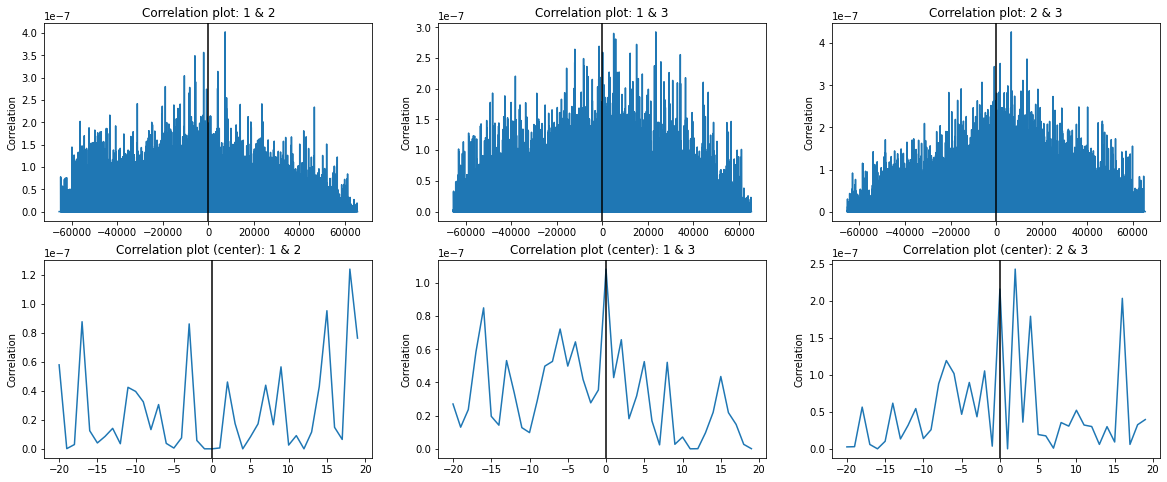

In [44]:
c = corr12_1d.shape[0]//2
s = 20
scale = 1e4

xs_full = np.arange(-c, c+1)
xs_small = np.arange(-s, s)

plt.figure(figsize=(20, 8))

plt.subplot(2, 3, 1)
plt.plot(xs_full, corr12_1d/scale)
plt.axvline(0, c='k')
plt.ylabel("Correlation")
plt.title("Correlation plot: 1 & 2")

plt.subplot(2, 3, 2)
plt.plot(xs_full, corr13_1d/scale)
plt.axvline(0, c='k')
plt.ylabel("Correlation")
plt.title("Correlation plot: 1 & 3")

plt.subplot(2, 3, 3)
plt.plot(xs_full, corr23_1d/scale)
plt.axvline(0, c='k')
plt.ylabel("Correlation")
plt.title("Correlation plot: 2 & 3")

plt.subplot(2, 3, 4)
plt.plot(xs_small, corr12_1d[c-s:c+s]/scale)
plt.axvline(0, c='k')
plt.ylabel("Correlation")
plt.title("Correlation plot (center): 1 & 2")

plt.subplot(2, 3, 5)
plt.plot(xs_small, corr13_1d[c-s:c+s]/scale)
plt.axvline(0, c='k')
plt.ylabel("Correlation")
plt.title("Correlation plot (center): 1 & 3")

plt.subplot(2, 3, 6)
plt.plot(xs_small, corr23_1d[c-s:c+s]/scale)
plt.axvline(0, c='k')
plt.ylabel("Correlation")
plt.title("Correlation plot (center): 2 & 3")


plt.show()